# Defining the Network

In [7]:
import random
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
import scipy.stats as stats
import itertools

In [8]:
def create_network(N, M, rate_constants, p, e):
    species = [f"A{i+1}" for i in range(N)]
    reactions = []

    for alpha in range(M):
        is_bimolecular = random.random() < p

        if is_bimolecular:
            reaction_species = random.sample(species, 4)
            reactants = reaction_species[:2]
            products = reaction_species[2:]
        else:
            reaction_species = random.sample(species, 2)
            reactants = reaction_species[:1]
            products = reaction_species[1:]
        
        reaction_species = set(reactants + products)
        
        catalyzed = random.random() < e
        if catalyzed:
            catalyst = random.sample(list(set(species) - reaction_species),1)[0]
            reactants.append(catalyst)
            products.append(catalyst)
        
        k_alpha = random.choice(rate_constants)

        reaction = {
            'reaction_id': alpha,
            'reactants': reactants,
            'products': products,
            'rate_constant': k_alpha
        }
        reactions.append(reaction)
    return species, reactions

def get_reaction_table(reactions):
    reaction_data = []
    for reaction in reactions:
        # Format the reaction data into a row for the table
        reaction_id = reaction['reaction_id']
        reactants = ' + '.join(reaction['reactants'])  # Join reactants as a string
        products = ' + '.join(reaction['products'])    # Join products as a string
        rate_constant = reaction['rate_constant']
        
        # Add row to the reaction data list
        reaction_data.append([reaction_id, reactants, products, rate_constant])

    # Print the table
    headers = ["Reaction ID", "Reactants", "Products", "Rate Constant"]
    print(tabulate(reaction_data, headers=headers, tablefmt="pretty"))

In [9]:
N = 25 # Number of species
M = 35 # Number of reactions
p = 0.3
e = 0.5
rate_constants = [1, 1e-1, 1e-2, 1e-3]

species, reactions = create_network(N, M, rate_constants, p, e)
get_reaction_table(reactions)

+-------------+-----------------+-----------------+---------------+
| Reaction ID |    Reactants    |    Products     | Rate Constant |
+-------------+-----------------+-----------------+---------------+
|      0      |    A10 + A12    |    A3 + A11     |      0.1      |
|      1      |    A11 + A2     |    A13 + A16    |     0.001     |
|      2      |    A18 + A2     |    A22 + A2     |       1       |
|      3      |       A2        |       A11       |     0.01      |
|      4      |       A15       |       A7        |     0.001     |
|      5      |    A14 + A3     |    A11 + A3     |      0.1      |
|      6      |       A16       |       A8        |       1       |
|      7      |       A10       |       A7        |     0.001     |
|      8      |     A5 + A2     |     A3 + A2     |     0.001     |
|      9      |  A18 + A7 + A3  |  A4 + A12 + A3  |     0.001     |
|     10      |       A14       |       A10       |     0.01      |
|     11      |    A24 + A2     |    A21 + A12  

# Gillespie Step

In [10]:
def gillespie_step(concentrations, reactions):
    total_propensity = 0
    propensities = []

    for reaction in reactions:
        propensity = reaction['rate_constant']
        for reactant in reaction['reactants']:
            propensity *= concentrations[reactant]
        propensities.append(propensity)
        total_propensity += propensity
    
    if total_propensity == 0:
        return None, None, None
    
    time_step = np.random.exponential(1/total_propensity)
    random_value = np.random.random() * total_propensity
    cumulative_propensity = 0
    reaction_index = -1
    for i, propensity in enumerate(propensities):
        cumulative_propensity += propensity
        if cumulative_propensity >= random_value:
            reaction_index = i
            break
    
    reaction = reactions[reaction_index]
    for reactant in reaction['reactants']:
        concentrations[reactant] -= 1 # reactant is consumed
        # if concentrations[reactant] == 0:
        #     continue
    
    for product in reaction['products']:
        concentrations[product] += 1 # product is produced
    
    return time_step, reaction, concentrations

In [11]:
def fetch_analytical_details(concentrations):
    print("Number of species : ", len(concentrations))
    # Find the maximum concentration of species
    max_conc = max(concentrations.values())

    # Find which species has the maximum concentration
    max_conc_species = [s for s in species if concentrations[s] == max_conc]

    # Find the minimum non-zero concentration of species
    min_conc = min([c for c in concentrations.values()])

    # Find which species has the minimum non-zero concentration
    min_conc_species = [s for s in species if concentrations[s] == min_conc]
    print("Number of species at minimum concentration :", len(min_conc_species))
    print("Minimum concentration : ", min_conc, "of species : ", min_conc_species)
    print("Maximum concentration : ", max_conc, "of species : ", max_conc_species)

    return min_conc, max_conc, min_conc_species, max_conc_species

# initial_conc is a literal
def simulation_with_plot(initial_conc,time_step, upper_limit_y):

    initial_concentrations = {s: initial_conc for s in species}

    concentrations = initial_concentrations.copy()
    #concentration_data
    concentration_data = {s: [initial_concentrations[s]] for s in species} 
    max_time = time_step
    current_time = 0

    times = [current_time]

    #concentration_data
    concentration_data = {s: [initial_concentrations[s]] for s in species}

    while current_time < max_time:
        time_step, reaction, concentrations = gillespie_step(concentrations, reactions)
        if time_step is None:
            break
        current_time += time_step
        times.append(current_time)

        for s in species:
            concentration_data[s].append(concentrations[s])

    
    print("Initial concentration :", initial_conc)
    fetch_analytical_details(concentrations)
    min_conc, max_conc, min_conc_species, max_conc_species = fetch_analytical_details(concentrations)
    plt.figure(figsize=(20, 10))

    # Loop through species and plot each with a label
    for s in species:
        plt.plot(times, concentration_data[s], label=s)
    
    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(1.05, 1))

    # Labels and title
    plt.xlabel('Time Step')
    plt.ylabel('Concentration of Species')
    plt.title('Concentration of Species Over Time (Gillespie Simulation)')
    plt.axhline(y=initial_conc, color='r', linestyle='--',label='Initial Conc')
    plt.axhline(y=min_conc, color='g', linestyle='--',label='Min Conc')
    
    plt.axhline(y=max_conc, color='r', linestyle='--',label='Max Conc')
    plt.ylim(0, upper_limit_y)
    plt.tight_layout()  # Adjust layout to avoid clipping the legend
    plt.show()

    # print the first time step when the concentration of each species is not equal to the initial concentration
    times_copy = times.copy()
    print("Smallest time_instant to occur : ", times_copy[1])

    return concentrations

def simulation_without_plot(initial_conc,time_step, upper_limit_y):

    initial_concentrations = {s: initial_conc for s in species}
    # print("Initial conc : ", initial_concentrations)
    concentrations = initial_concentrations.copy()
    #concentration_data
    concentration_data = {s: [initial_concentrations[s]] for s in species} 
    max_time = time_step
    current_time = 0

    times = [current_time]

    #concentration_data
    concentration_data = {s: [initial_concentrations[s]] for s in species}

    while current_time < max_time:
        time_step, reaction, concentrations = gillespie_step(concentrations, reactions)
        if time_step is None:
            break
        current_time += time_step
        times.append(current_time)

        for s in species:
            concentration_data[s].append(concentrations[s])

    # print the first time step when the concentration of each species is not equal to the initial concentration
    times_copy = times.copy()
    # print("Smallest time_instant to occur : ", times_copy[1])

    steady_state_concentrations = concentrations
    # print("Final conc : ", steady_state_concentrations)
    
    return steady_state_concentrations


Initial concentration : 100
Number of species :  25
Number of species at minimum concentration : 13
Minimum concentration :  0 of species :  ['A2', 'A4', 'A5', 'A6', 'A8', 'A10', 'A14', 'A16', 'A18', 'A20', 'A22', 'A23', 'A24']
Maximum concentration :  1026 of species :  ['A3']
Number of species :  25
Number of species at minimum concentration : 13
Minimum concentration :  0 of species :  ['A2', 'A4', 'A5', 'A6', 'A8', 'A10', 'A14', 'A16', 'A18', 'A20', 'A22', 'A23', 'A24']
Maximum concentration :  1026 of species :  ['A3']


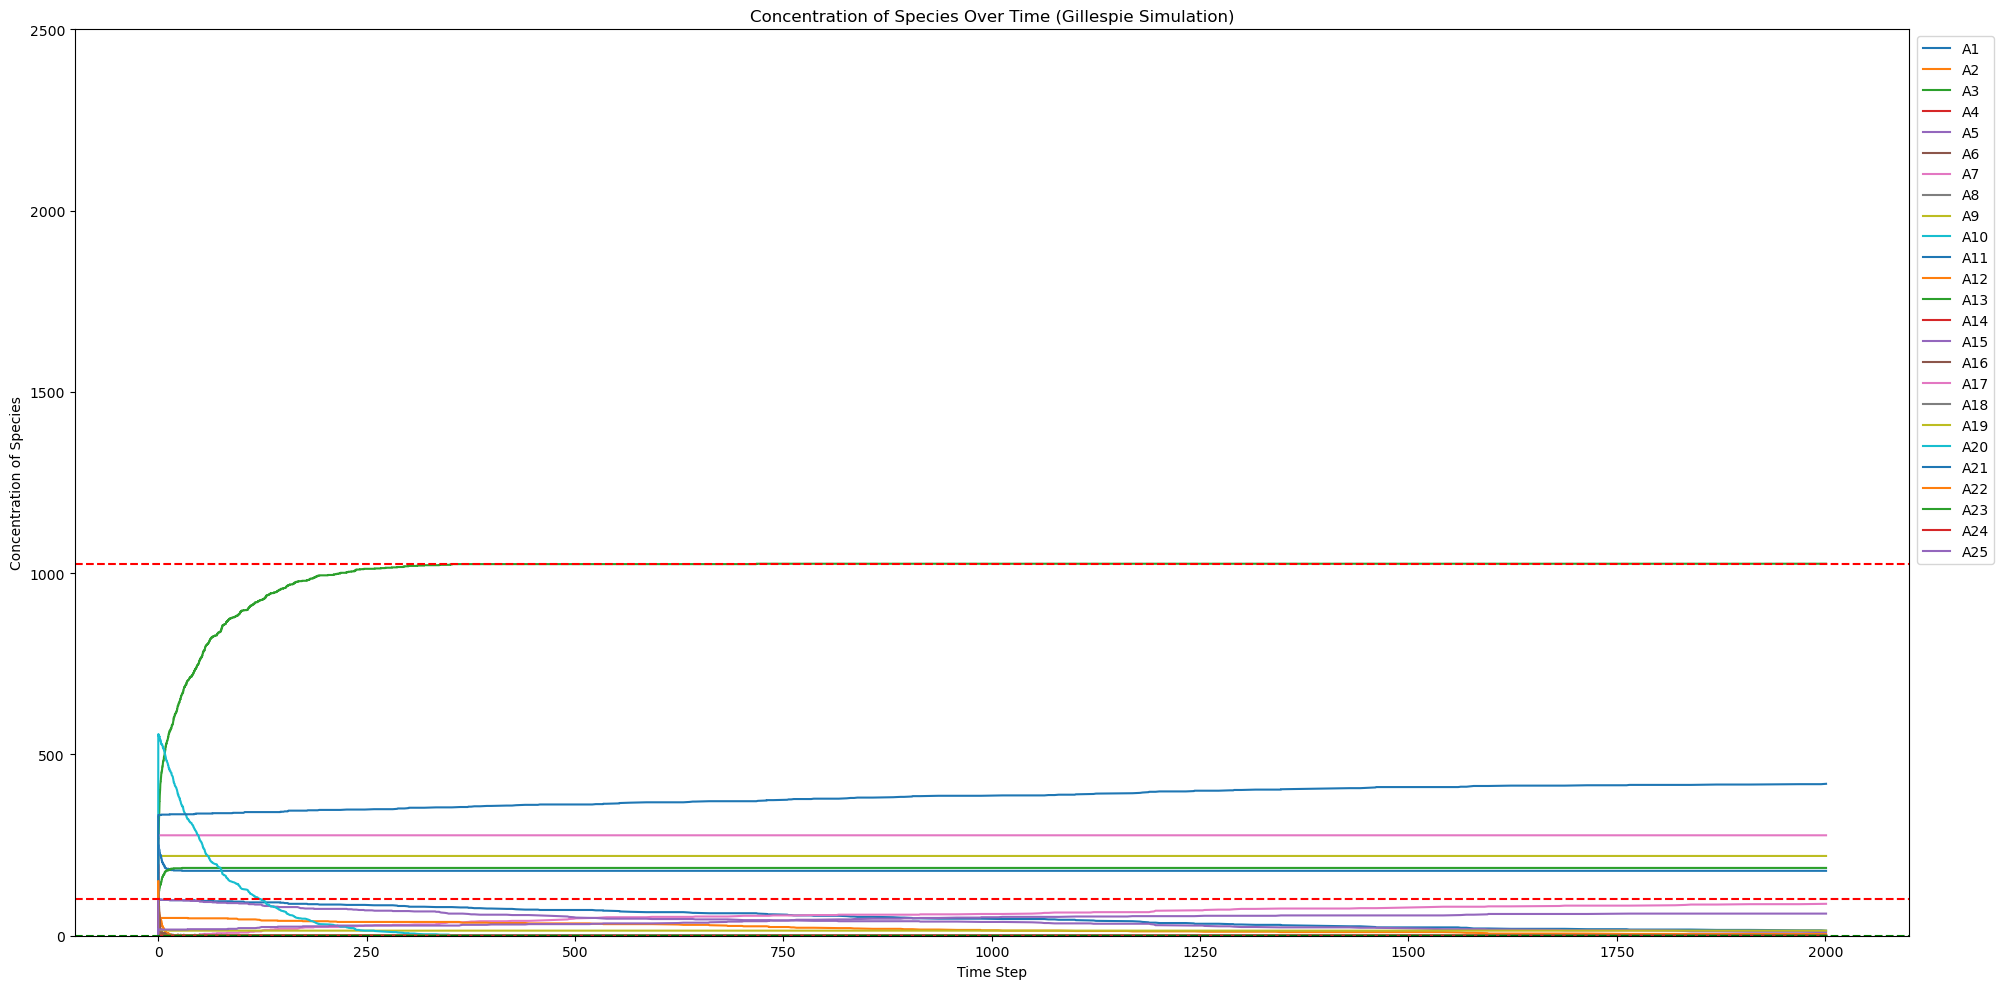

Smallest time_instant to occur :  3.4195896860217225e-06


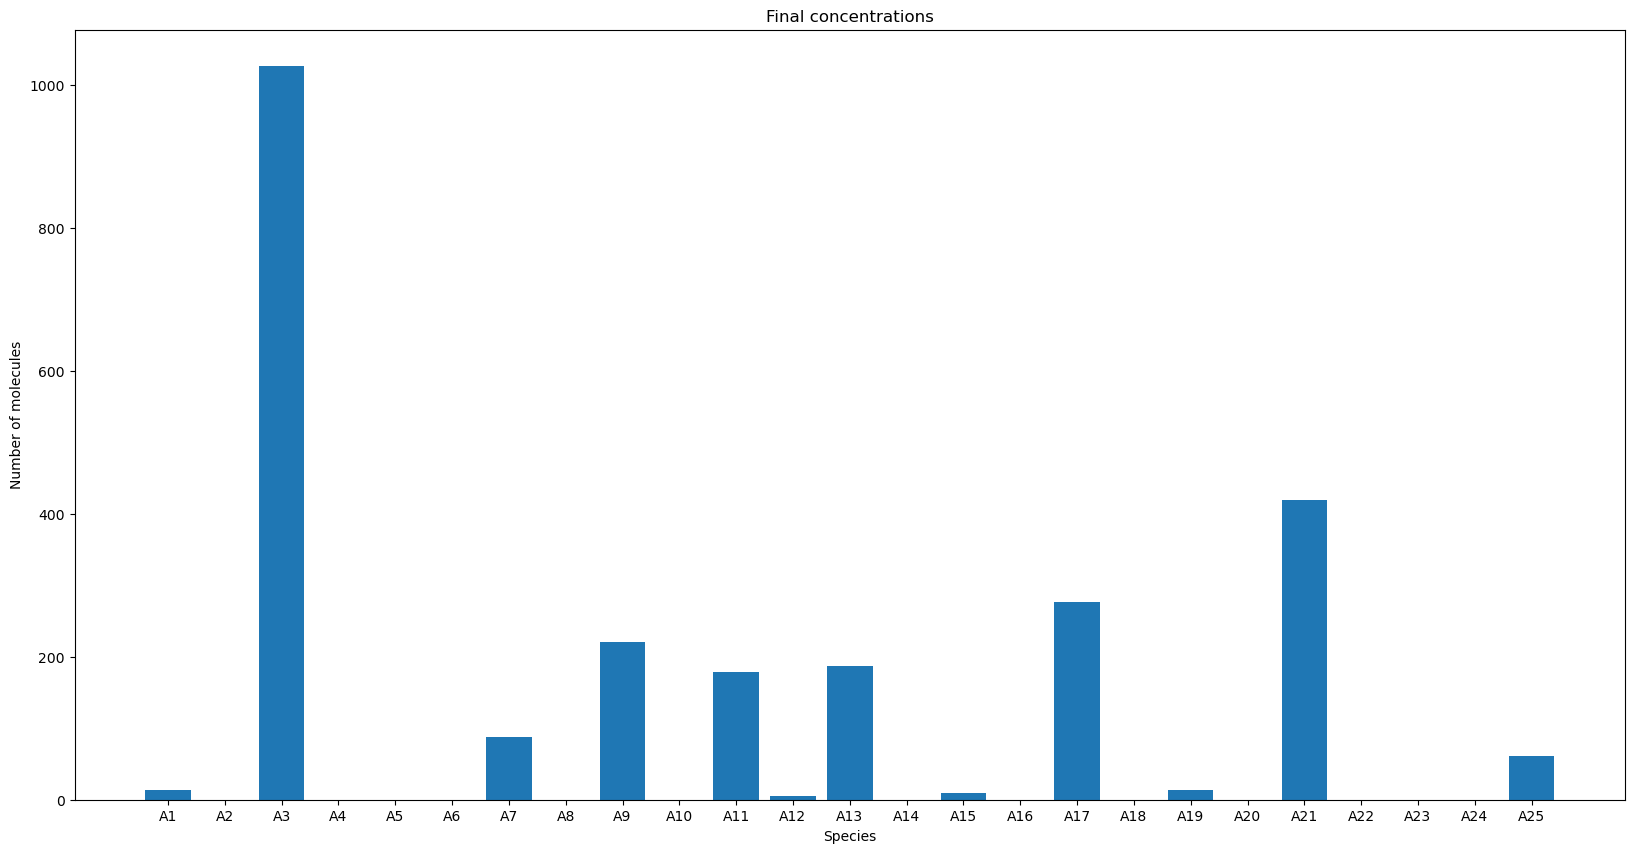

In [12]:
initial_conc = 100
time_step = 2000
final_concentrations = simulation_with_plot(initial_conc,time_step,25*initial_conc)
plt.figure(figsize=(20, 10))
plt.title("Final concentrations")
plt.xlabel("Species")
plt.ylabel("Number of molecules")
plt.bar(final_concentrations.keys(), final_concentrations.values())
plt.show()

(25, 75, 0.3, 0.5, 100)
Number of species :  25 
Number of reactions :  75 
p =  0.3 
e =  0.5 
Initial conc =  100
Initial concentration : 100
Number of species :  25
Number of species at minimum concentration : 17
Minimum concentration :  0 of species :  ['A1', 'A3', 'A4', 'A5', 'A7', 'A8', 'A9', 'A12', 'A13', 'A14', 'A16', 'A18', 'A19', 'A20', 'A22', 'A23', 'A25']
Maximum concentration :  1229 of species :  ['A24']
Number of species :  25
Number of species at minimum concentration : 17
Minimum concentration :  0 of species :  ['A1', 'A3', 'A4', 'A5', 'A7', 'A8', 'A9', 'A12', 'A13', 'A14', 'A16', 'A18', 'A19', 'A20', 'A22', 'A23', 'A25']
Maximum concentration :  1229 of species :  ['A24']


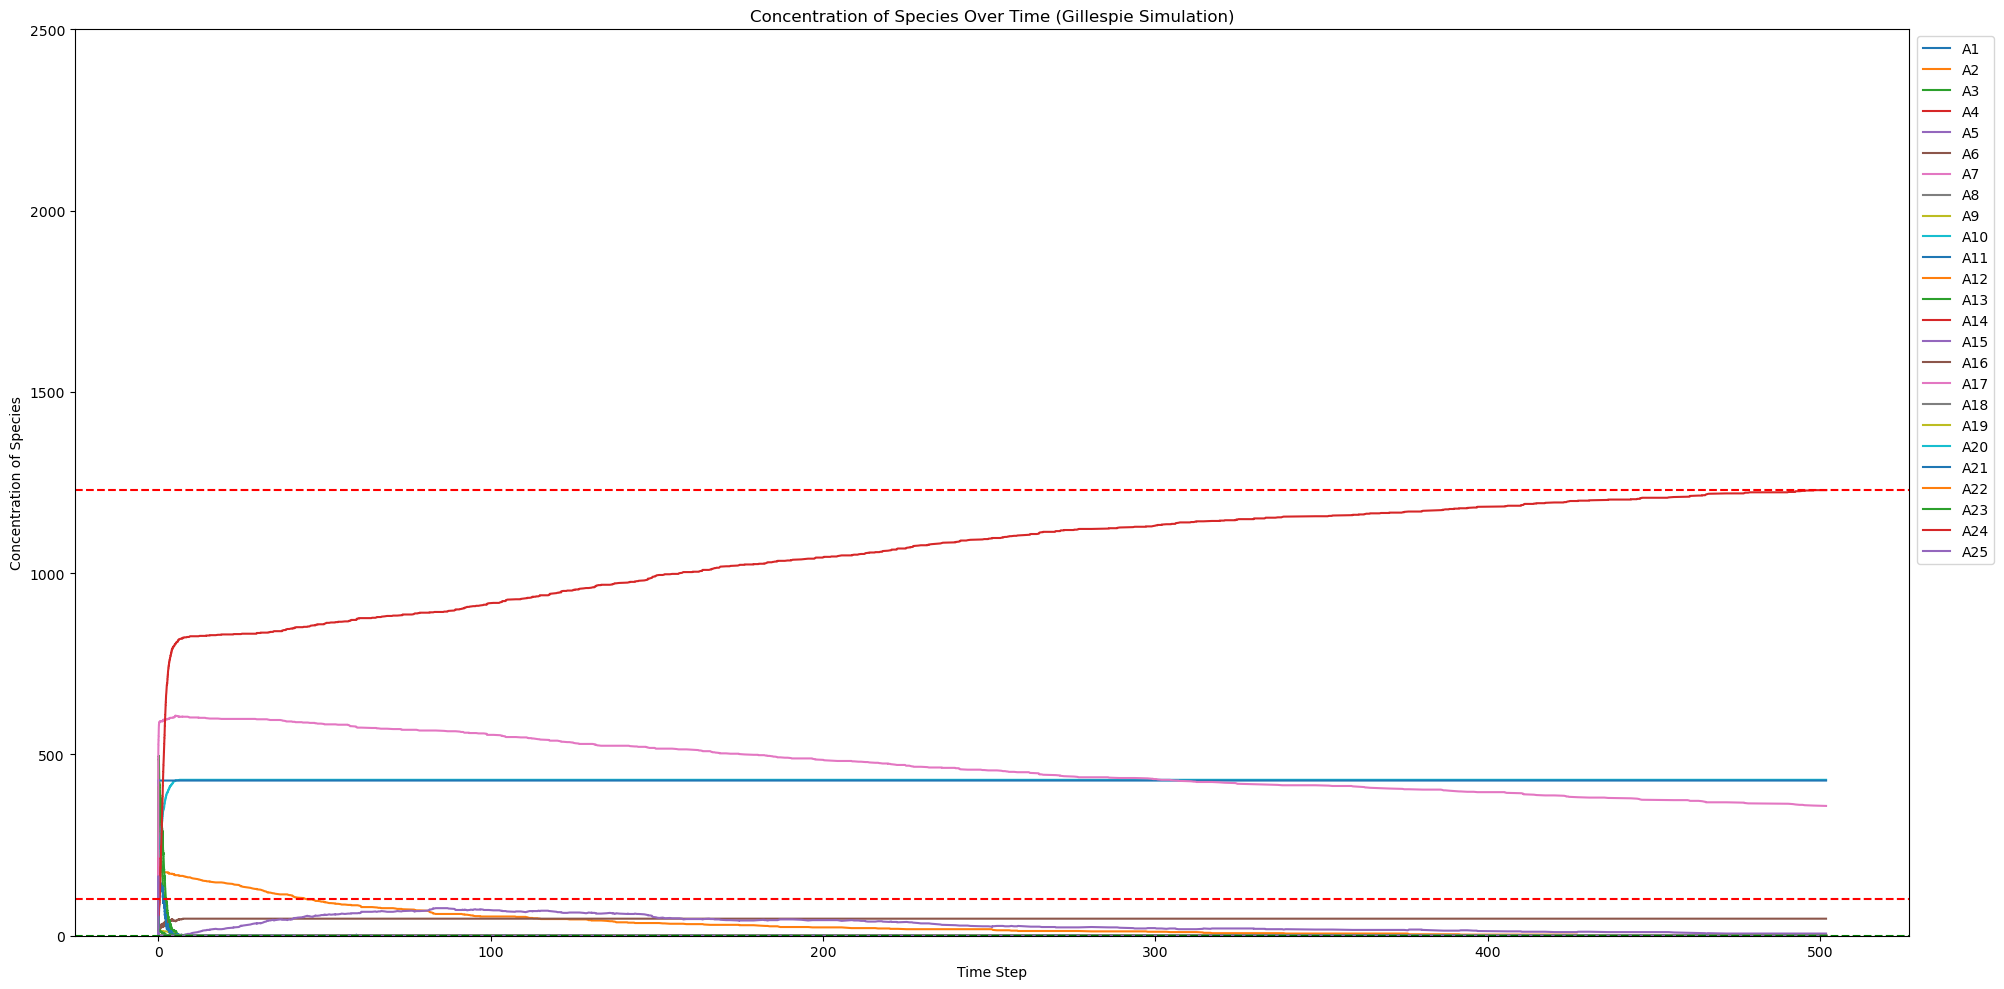

Smallest time_instant to occur :  6.789730581723769e-07


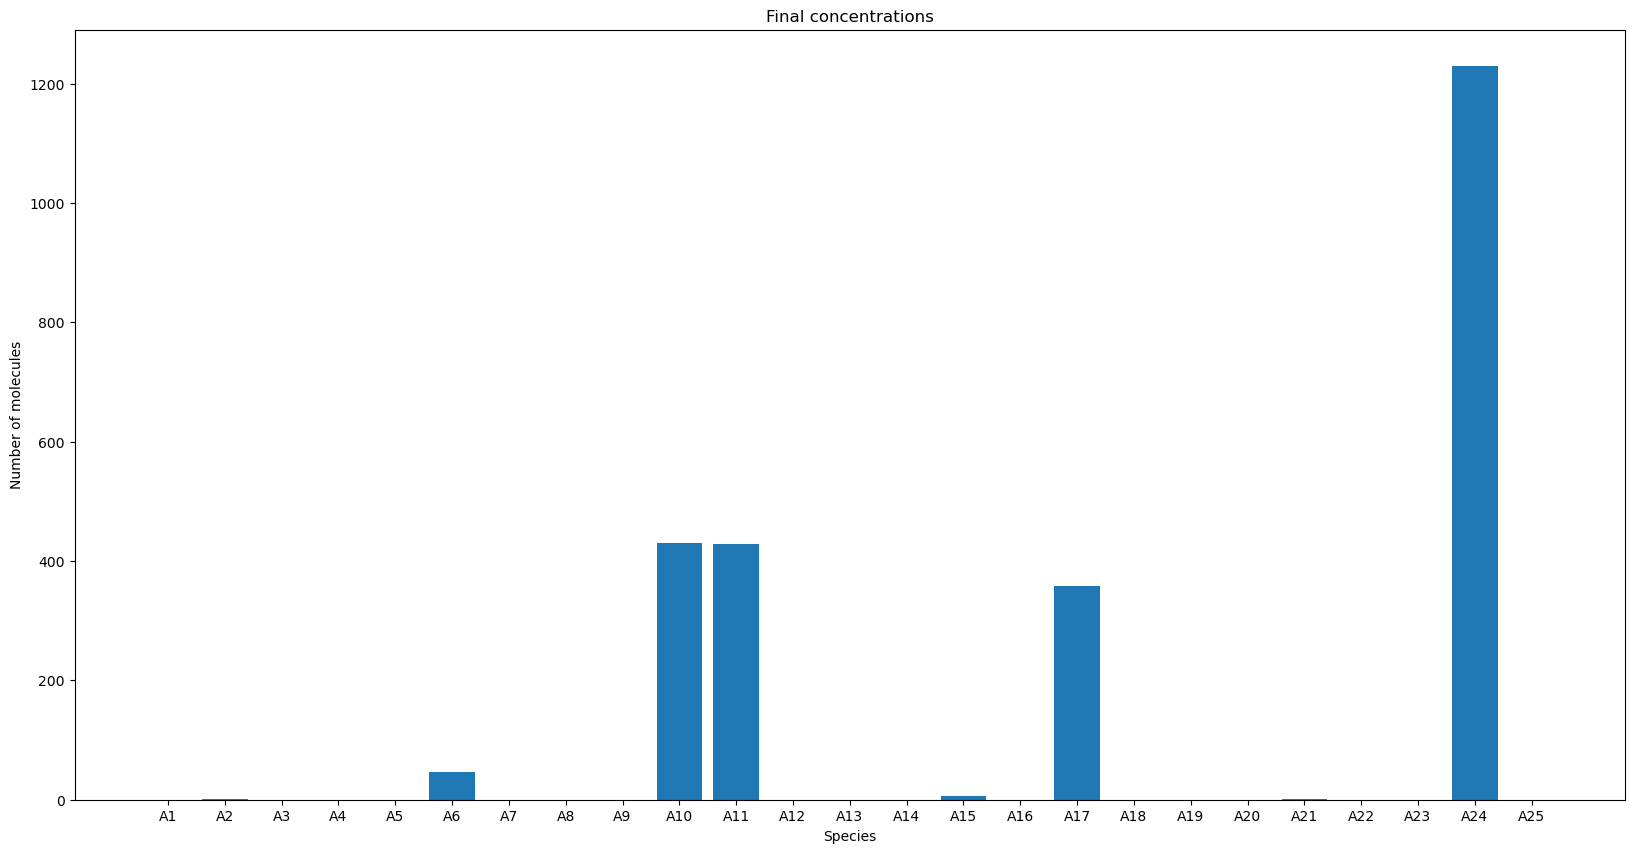

(25, 100, 0.3, 0.5, 100)
Number of species :  25 
Number of reactions :  100 
p =  0.3 
e =  0.5 
Initial conc =  100


In [ ]:
N = [25,50, 75, 100]
M = [75,100]
p = [0.3]
e = [0.5]
initial_conc = [100]

time_step = 500

species_concentration_over_multiple_simulations = {}
for i in range(0,len(N)):
    species_concentration_over_multiple_simulations[N[i]] = []
for combination in itertools.product(N,M,p,e,initial_conc):
    print(combination)
    print("Number of species : ",combination[0], "\nNumber of reactions : ", combination[1], "\np = ",combination[2], "\ne = ",combination[3], "\nInitial conc = ",combination[4])
    n,m,P,E,IC = combination
    species, reactions = create_network(n,m,rate_constants,P,E)
    # steady_state_concentrations = simulation_without_plot(IC, time_step, 10*IC)
    final_concentrations = simulation_with_plot(IC,time_step, 25*IC)
    plt.figure(figsize=(20, 10))
    plt.title("Final concentrations")
    plt.xlabel("Species")
    plt.ylabel("Number of molecules")
    plt.bar(final_concentrations.keys(), final_concentrations.values())
    plt.show()

# MTD